# MOBILITY MOTIFS FROM MRMT 2015

## 0. DESCRIPTION

This script generates activity patterns according to the methodology of Schultheiss et al. (2021). 

It requires as input the dataset `etappen.csv` and as output the file `motifs_mrmt_2015_all_tag_purpose.pkl`, which contains the generated motifs and socio-demographic information on the individuals.

## 1. DATA & SETTINGS

In [1]:
import pandas as pd
import networkx as nx
import math
import time
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import geopandas as gpd
from geopandas.tools import sjoin

from itertools import groupby
import multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool


pd.set_option('display.max_columns', 999)


#'HHNR', household number
#'ETNR', etappen number
#'f52900', trip purpose
#'f51100', start time of the trip
#'f51400', end time of the trip
#'S_X', origin lon
#'S_Y', origin lat
#'Z_X', destination lon
#'Z_Y', destionation lat
#'W_X', main home lon
#'W_Y', main home lat
#'Z_PLZ', goal zip code
#'S_PLZ', start zip code
col_to_use = ['HHNR', 'ETNR','f52900', 'f51100', 'f51400', 'W_X', 'W_Y', 'S_X', 'S_Y', 'Z_X', 'Z_Y', 'Z_PLZ', 'S_PLZ']


In [2]:
etappen = pd.read_csv('data/etappen.csv', sep=',', decimal=".",encoding='ISO-8859-1', usecols=col_to_use)
etappen.head(3)

,HHNR,ETNR,f52900,f51100,f51400,S_X,S_Y,S_PLZ,Z_X,Z_Y,Z_PLZ,W_X,W_Y
0,100004,1,12,900,905,8.16896,47.44724,5116,8.16805,47.44229,5116,8.16896,47.44724
1,100010,1,9,510,525,9.04765,46.21948,6517,9.05594,46.22460,6533,9.04765,46.21948
2,100010,2,4,750,755,9.05594,46.22460,6533,9.05091,46.22372,6532,9.04765,46.21948


## 2. PREPARE DATA TO CREATE MOTIFS

**Assumptions**

1. Do not consider activities at home (set purpose = 0)
2. Filter out users that have only one etappen (marginal loss)
3. Filter out users that do not start or finish their day at home location (loss 16%)
4. Aggregate in one trip all etappens to switch mode (purpose == 1)
5. Nodes are triples of unique (purpose, lon, lat) i.e. location-activity based motifs
6. Remove people that have at least one trip across Swiss borders during the day

In [7]:
%%time
nodes = etappen.copy()
# Rename columns
nodes.rename(columns={'f52900':'purpose', 'ETNR':'node_number'}, inplace=True)

nodes['lon'] = nodes['Z_X']
nodes['lat'] = nodes['Z_Y']
nodes['zip_code'] = nodes['Z_PLZ']
nodes['zip_code_s'] = nodes['S_PLZ']

# The departure of the etappen becomes the finished_at of the previous activity
nodes['started_at'] = nodes.f51400
nodes['finished_at'] = nodes.groupby('HHNR')['f51100'].shift(-1, fill_value=1440)

# Replace purposes with 0 for locations == (W_X, W_Y), i.e., main home
nodes.loc[np.where(((nodes.lon == nodes.W_X) & (nodes.lat == nodes.W_Y)))[0].tolist(), 'purpose'] = 0

# Artificially add the first node
first_node = nodes[['HHNR', 'S_X', 'S_Y', 'W_X', 'W_Y', 'f51100', 'zip_code', 'zip_code_s']].drop_duplicates(subset='HHNR', keep='first', ignore_index=True)
first_node[['node_number', 'started_at']] = 0
first_node.rename(columns={'S_X':'lon', 'S_Y':'lat', 'f51100':'finished_at'}, inplace=True)
first_node['purpose'] = 0  # purpose set to "home"
first_node.loc[np.where(((first_node.lon != first_node.W_X) & (first_node.lat != first_node.W_Y)))[0], 'purpose'] = 12  # "other"

# Merge the first activity with the rest of the activities
nodes = pd.concat([nodes, first_node]).sort_values(by=['HHNR', 'node_number']).reset_index(drop=True)

# Drop the construction columns
nodes = nodes[['HHNR', 'started_at', 'finished_at', 'purpose', 'lon', 'lat', 'zip_code', 'zip_code_s']]

# Set purpose == 11 to 0 (i.e., home)
nodes.purpose.replace({11: 0}, inplace=True)

# Simply remove the lines for which purpose == 1 (i.e., mode transfer)
nodes = nodes.loc[nodes.purpose != 1].reset_index(drop=True)

# Correct the end time if overnight
nodes.loc[np.where((nodes.started_at > nodes.finished_at))[0], 'finished_at'] = 2160  # set to noon the day after // OR // nodes.loc[np.where((nodes.started_at > nodes.finished_at))[0], 'started_at']

# Identify the unique tuples of location-purpose
event_based_on = ['purpose']  # 'purpose','lon', 'lat'

nodes_ = nodes[event_based_on].drop_duplicates(ignore_index=True) \
    .assign(node_id=lambda x: x.index.astype(str))
nodes = nodes.merge(nodes_, on=event_based_on, how='left')

# Drop subsequent activities with the same node_id
nodes['node_id_next'] = nodes.groupby('HHNR').node_id.shift(-1, fill_value=0)

nodes.reset_index(drop=True, inplace=True)
index_to_drop = []
i = 0
for i_0 in nodes.loc[nodes.node_id == nodes.node_id_next].index:
    if i_0 <= i:
        index_to_drop.append(i_0)
        continue
    else:
        i = i_0
        node_id = nodes.loc[i, 'node_id']

        while node_id == nodes.loc[i, 'node_id_next']:
            i += 1
            index_to_drop.append(i)

        nodes.loc[i_0, 'finished_at'] = nodes.loc[i, 'finished_at']
        nodes.loc[i_0, 'node_id_next'] = nodes.loc[i, 'node_id_next']

nodes.drop(index_to_drop, inplace=True)
nodes.reset_index(drop=True, inplace=True)

# Remove HHNRs with only one observation after all the transformations before
size_ = nodes.groupby('HHNR').size()
nodes = nodes[nodes.HHNR.isin(size_[size_ > 2].index)]

# Edge tuples
nodes['edges'] = list(zip(nodes.node_id.astype(str), nodes.node_id_next.astype(str)))

# Retrieve shape of countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.rename(columns={'name':'country'}, inplace=True)
world = world.to_crs("EPSG:2056")
#world.geometry = world.geometry.buffer(5000)
nodes = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes.lon, nodes.lat), crs="EPSG:4326")
nodes = nodes.to_crs("EPSG:2056")
nodes = sjoin(nodes, world[['country','geometry']], how='left')

# Parse geometry ot a tuple of coordinates in the right projection
nodes['coordinates'] = list(zip(nodes.geometry.x, nodes.geometry.y))

# Edge tuples
nodes['edges'] = list(zip(nodes.node_id.astype(str), nodes.node_id_next.astype(str)))

# Remove the HHNRs who have at least one trip outside CH
# Create a list of HHNRs having a negative value in the "zip_code" column
bad_households = nodes[nodes["zip_code"] < 0]["HHNR"].unique()
bad_households_ = nodes[nodes["zip_code_s"] < 0]["HHNR"].unique()

# Remove all the lines of households with an HHNR present in the "bad_households" list
nodes = nodes[~nodes["HHNR"].isin(bad_households)]
nodes = nodes[~nodes["HHNR"].isin(bad_households_)]

nodes.head()

CPU times: total: 33.3 s
Wall time: 36.1 s


,HHNR,started_at,finished_at,purpose,lon,lat,zip_code,zip_code_s,node_id,node_id_next,edges,geometry,index_right,country,coordinates
2,100010,0,510,0,9.04765,46.21948,6533,6517,0,2,"(0, 2)",POINT (2724147.369 1119942.712),127.0,Switzerland,"(2724147.3685593074, 1119942.7121987299)"
3,100010,525,750,9,9.05594,46.22460,6533,6517,2,3,"(2, 3)",POINT (2724775.182 1120524.910),127.0,Switzerland,"(2724775.182200546, 1120524.9104595871)"
4,100010,755,770,4,9.05091,46.22372,6532,6533,3,0,"(3, 0)",POINT (2724389.181 1120419.118),127.0,Switzerland,"(2724389.1808244293, 1120419.1175917918)"
5,100010,780,825,0,9.04765,46.21948,6517,6532,0,4,"(0, 4)",POINT (2724147.369 1119942.712),127.0,Switzerland,"(2724147.3685593074, 1119942.7121987299)"
6,100010,830,1050,8,9.05055,46.22125,6517,6517,4,0,"(4, 0)",POINT (2724367.052 1120144.027),127.0,Switzerland,"(2724367.0517112575, 1120144.0267014955)"


## 3. CREATE MOTIFS

In [8]:
def get_motifs(nodes):
    """
    Generate motifs based on node data.

    Args:
        nodes (pd.DataFrame): DataFrame containing node data.

    Returns:
        pd.DataFrame: DataFrame with generated motifs.

    """
    # Create empty DataFrame to store motifs
    mtfs = pd.DataFrame(index=nodes.HHNR.unique())
    mtfs['graph'] = np.nan
    mtfs['graph'] = mtfs['graph'].astype('object')
    mtfs['graph_flat'] = np.nan
    mtfs['graph_flat'] = mtfs['graph_flat'].astype('object')
    mtfs['motif_type'] = np.nan
    mtfs['motif_type'] = mtfs['motif_type'].astype('object')

    for hhnr_ in mtfs.index:
        # Filter nodes for a specific HHNR
        nodes_ = nodes.loc[nodes.HHNR == hhnr_]

        try:
            # Extract relevant attributes from nodes
            attributes = nodes_.drop_duplicates(subset=['HHNR', 'node_id', 'started_at', 'finished_at'])[['HHNR', 'node_id', 'coordinates', 'started_at', 'finished_at']]
            attributes.set_index('node_id', inplace=True)

            # Group attributes by node_id and aggregate time values
            attributes_time = attributes.groupby(by=['node_id']).aggregate({'started_at': list, 'finished_at': list})
            attributes_time = attributes_time.groupby(level=0).apply(lambda attributes_time: attributes_time.xs(attributes_time.name).to_dict()).to_dict()

            # Create a directed graph and add edges and attributes
            G = nx.DiGraph()
            G.add_edges_from(nodes_.edges[:-1].to_list())
            nx.set_node_attributes(G, attributes_time, name='time')

            # Store the generated graph and flattened graph array
            mtfs.at[hhnr_, 'graph'] = G
            mtfs.at[hhnr_, 'graph_flat'] = nx.to_numpy_array(G).flatten().tolist()

            # Convert purpose values to strings and join them to create motif type
            purpose_strings = [str(purpose) for purpose in nodes_['purpose'].tolist()]
            motif_type = ','.join(purpose_strings)

            # Store the motif type
            mtfs.at[hhnr_, 'motif_type'] = motif_type

        except:
            print('Exception raised for ' + str(hhnr_))
            continue

    return mtfs.reset_index(drop=False)

In [9]:
%%time

cores = 4

# Obtain HHNRs that start or return home in the first or last etappen (losing 16% of observations)
dep_home = etappen[['HHNR', 'S_X', 'S_Y', 'W_X', 'W_Y']].drop_duplicates(subset='HHNR', keep='first')
dep_home = dep_home.loc[(dep_home.S_X == dep_home.W_X) & (dep_home.S_Y == dep_home.W_Y), 'HHNR'].values

return_home = etappen[['HHNR', 'Z_X', 'Z_Y', 'W_X', 'W_Y']].drop_duplicates(subset='HHNR', keep='last')
return_home = return_home.loc[(return_home.Z_X == return_home.W_X) & (return_home.Z_Y == return_home.W_Y), 'HHNR'].values

dep_and_return_home = np.intersect1d(dep_home, return_home)

# Split the DataFrame into arrays based on the number of cores
user_ids = np.array_split(dep_and_return_home, cores, axis=0)
nodes_split = []
for u in user_ids:
    nodes_split.append(nodes.loc[nodes.HHNR.isin(u.tolist())])

df_out = []
for node in nodes_split:
    df_out.append(get_motifs(node))

# Combine the results into a single DataFrame
mtf = pd.DataFrame(np.vstack(df_out), columns=['HHNR', 'DiGraph_motif', 'motif_flat', 'motif_type'])
mtf.HHNR = mtf.HHNR.astype(int)
mtf = mtf.set_index('HHNR')

# Parse motif_id
mtf['motif_id'] = 99

for i_, mtf_ in enumerate(mtf.motif_type.value_counts().index[:12]):
    mtf.loc[mtf.motif_type.apply(lambda x: x == mtf_), 'motif_id'] = i_ + 1

CPU times: total: 6min
Wall time: 6min 7s


In [10]:
mtf.head()

,DiGraph_motif,motif_flat,motif_type,motif_id
HHNR,,,,
100010,"(0, 2, 3, 4)","[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","0,9,4,0,8,0",99
100021,"(0, 3, 4)","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]","0,4,0,8,0",5
100028,"(0, 4)","[0.0, 1.0, 1.0, 0.0]","0,8,0",1
100037,"(0, 4, 3)","[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]","0,8,4,8,0",99
100049,"(0, 4)","[0.0, 1.0, 1.0, 0.0]","0,8,0,8,0",4


## 4. ADD SOCIODEMOGRAPHIC INFORMATION

Here we add sociodemographic attributes (age, day, employment status, professional position, etc...) to be able to analyse these attributes later.

In [12]:
mtf_ = mtf.copy()
col_to_use = ['HHNR','tag','ERWERB','alter','f40800_01','f41100_01','f81000','f81100']

# Reading CSV file
ziel = pd.read_csv('data/zielpersonen.csv', sep=',', decimal=".", encoding='ISO-8859-1', usecols=col_to_use)

# Rename the columns
ziel.rename(columns={'f40800_01':'employment_status', 'f41100_01':'professional_pos', 'f81000' : 'work_sektor12',
                    'f81100' : 'work_sektor3'}, inplace=True)

# Merge the two DataFrames using the "HHNR" column as the merge key
mtf_ = mtf_.merge(ziel, on='HHNR', how='left')
mtf_ = mtf_.set_index('HHNR')

mtf_.head()

,DiGraph_motif,motif_flat,motif_type,motif_id,alter,tag,employment_status,professional_pos,work_sektor12,work_sektor3,ERWERB
HHNR,,,,,,,,,,,
100010,"(0, 2, 3, 4)","[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","0,9,4,0,8,0",99,8,6,-99,-99,-99,-99,3
100021,"(0, 3, 4)","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]","0,4,0,8,0",5,68,6,-99,-99,-99,-99,4
100028,"(0, 4)","[0.0, 1.0, 1.0, 0.0]","0,8,0",1,61,1,4,1,-99,-99,2
100037,"(0, 4, 3)","[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]","0,8,4,8,0",99,30,6,-99,-99,-99,-99,4
100049,"(0, 4)","[0.0, 1.0, 1.0, 0.0]","0,8,0,8,0",4,11,6,-99,-99,-99,-99,3


## 5. TEST THE GENERATION

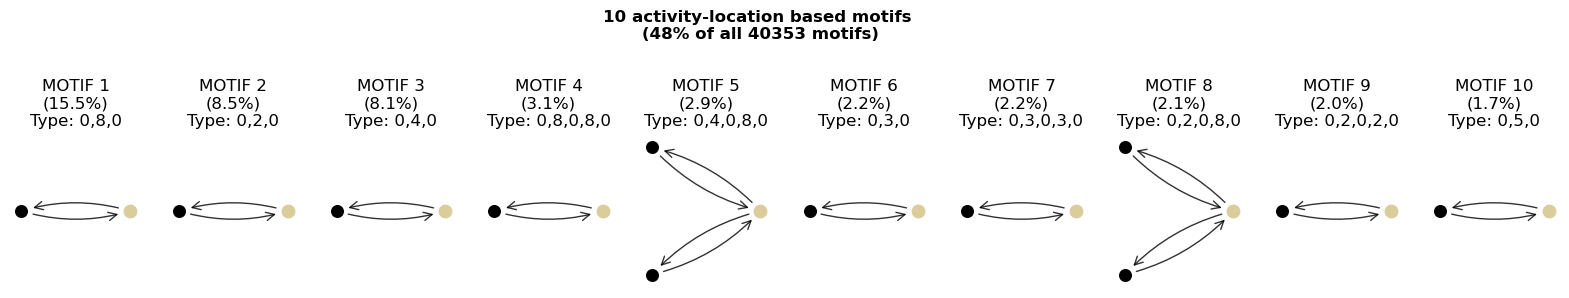

In [13]:
n_mtfs = 10

# Calculate the percentage of each motif type
count_mtf = mtf_['motif_type'].value_counts(normalize=True) * 100

# Calculate the explained variance based on the top n_mtfs motif types
explained_variance = round(mtf_.motif_type.value_counts(normalize=True)[:n_mtfs].sum() * 100, 1)

# Create a figure for displaying the motifs
counter = 1
f = plt.figure(frameon=False, figsize=(20, 2))
f.suptitle('%s activity-location based motifs \n(%d%% of all %s motifs)' % (n_mtfs, explained_variance, len(mtf_)),
           fontweight='bold', y=1.5)

# Iterate over the top n_mtfs motif types
for i in mtf_['motif_type'].value_counts().index[:n_mtfs]:
    # Retrieve the motif and its details
    motif = mtf_.loc[mtf_['motif_type'] == i, 'motif_flat'].values[1]
    
    # Create a subplot for each motif
    axis = f.add_subplot(1, n_mtfs, counter, xticks=[], yticks=[], frame_on=False,
                         title='MOTIF %s\n(%s%%)\nType: %s' % (counter, round(count_mtf[counter-1], 1), i))
    
    dim = np.sqrt(len(motif)).astype(int)
    motif_arr = np.asarray(motif).reshape((dim, dim)) 
    
    # Create a directed graph from the motif array
    G = nx.DiGraph(motif_arr)
    pos = nx.circular_layout(G)
    
    # Draw the edges of the graph
    nx.draw_networkx_edges(G, pos, edge_color='black', alpha=0.80, arrowstyle="->", arrowsize=15, width=1,
                           connectionstyle='arc3,rad=+0.15')
    
    # Draw the nodes of the graph
    nx.draw_networkx_nodes(G, pos, node_color='black', node_size=70, nodelist=list(range(1, dim)))
    nx.draw_networkx_nodes(G, pos, node_color='#dbcc9c', node_size=80, nodelist=[0])
    
    counter += 1

plt.show()

## 6. SAVE MOTIFS

In [14]:
mtf_.to_pickle('motifs_mrmt_2015_all_tag_purpose.pkl')